# Inférence de la Typologie à partir des données de MRV (Stratégie ML Naive)
La variable TYPO présente les types de dysfocntionnements et d'effets des dispositifs. Il y a 3 varaibles concernée
- TYPE DE DYSFONCTIONNEMENT
- CONSEQUENCE DYSFONCTIONNEMENT
- TYPE D'EFFET




**Stratégie ML 1**

Dans ce problème de classification de texte multiclasse, le pipeline sera le suivant :
1. Nettoyer les données textuelles 
2. Nettoyage des observations (Traitement des doublons au moment de la séparation du train et du test)
3. Construction des features textuelles (Deux tfidf)
4. Entrainement de l'algorithme de classification (SVM probabilisé)
5. Evaluation du modèle (Accuracy, Balanced Accuracy, F1-weighted)


## 0) Chargement des librairies

In [1]:
import warnings
warnings.filterwarnings('ignore')

from pprint import pprint
from time import time
import logging

import pandas as pd

import numpy as np
import sklearn as sk
import seaborn as sns

import nltk
from nltk import word_tokenize
lang ='french'

import clean_text





import matplotlib.pyplot as plt


from sklearn.feature_extraction.text import TfidfVectorizer,HashingVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GroupShuffleSplit
from sklearn.feature_extraction.text import TfidfTransformer,CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import cross_val_score, cross_validate

from sklearn.metrics import confusion_matrix, accuracy_score, balanced_accuracy_score,f1_score
from sklearn import metrics
from sklearn.linear_model import SGDClassifier
from sklearn.decomposition import TruncatedSVD,IncrementalPCA,SparsePCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.calibration import CalibratedClassifierCV

import spacy
nlp =spacy.load('fr')
from spacy.lang.fr.stop_words import STOP_WORDS

## 0.1 Chargement et exploration des données
### 0.1.1 type de vigilance

In [2]:
%time
df_declaration_mrv = pd.read_csv("data/data_mrv/declaration_mrv_complet.csv")#delimiter=';',encoding='ISO-8859-1')
id_to_dco = pd.read_csv("data/ref_MRV/referentiel_dispositif.csv",delimiter=';',encoding='ISO-8859-1')

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 11.2 µs


In [3]:
df_declaration_mrv.iloc[0]

Unnamed: 0                                                                       0
NUMERO_DECLARATION                                                        R1700004
TYPE_DECLARATION                                                             CERFA
TYPE_DECLARANT                           Etablissements et professionnels de santé
NB_PATIENT_CONCERNE                                                              1
NB_DISPOSITIF_CONCERNE                                                           1
DESCRIPTION_INCIDENT             Le guide est resté coincé à l'intérieur de la ...
ETAT_PATIENT                                                   Changement de sonde
ACTION_PATIENT                                 Matériel disponible au sce économat
DCO_ID                                                                        2851
DCO                                                 SONDE DE STIMULATION CARDIAQUE
LIBELLE_COMMERCIAL                                           SONDE ATTAIN PERFORMA
REFE

In [4]:
df_declaration_mrv['TYPE_VIGILANCE'].unique()

array(['Matériovigilance', 'Réactovigilance'], dtype=object)

In [5]:
df_group = df_declaration_mrv.groupby('TYPE_VIGILANCE')
df_mat = df_group.get_group('Matériovigilance')
df_rea = df_group.get_group('Réactovigilance')
print('materio : ', len(df_mat))
print('reacto  : ', len(df_rea))

materio :  75569
reacto  :  1385


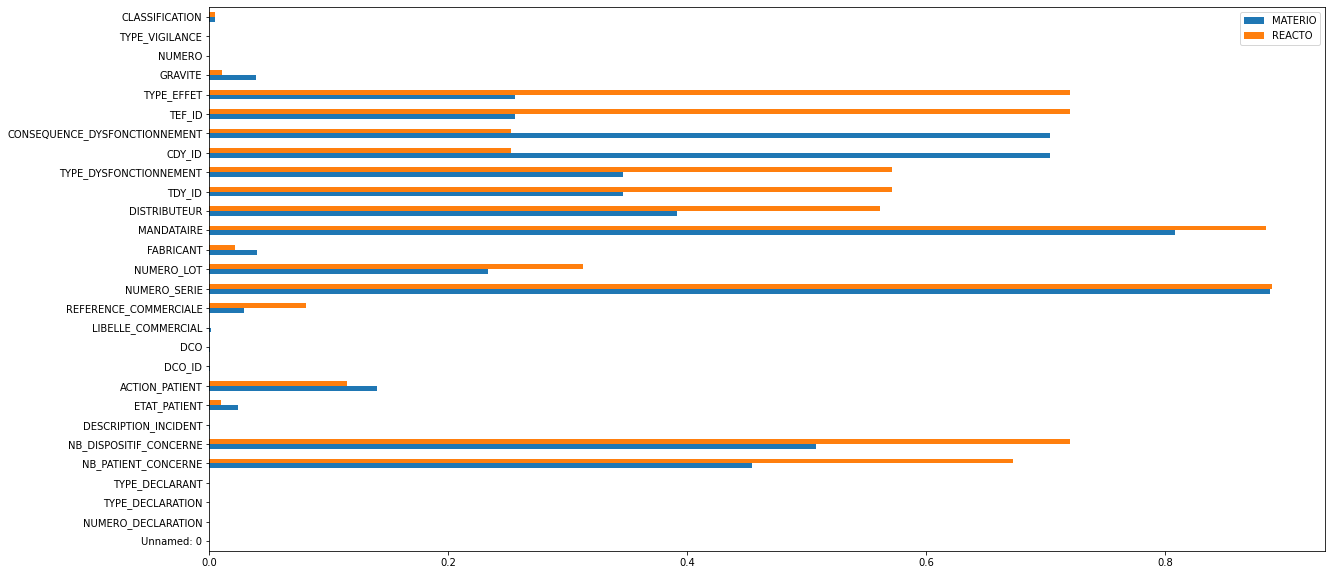

In [6]:
L_mat = df_mat.isna().sum()/len(df_mat)
L_rea = df_rea.isna().sum()/len(df_rea)

df = pd.DataFrame(index=df_declaration_mrv.columns)
df['MATERIO'] = L_mat
df['REACTO'] = L_rea
df.plot(kind='barh',figsize = (20,10))
plt.show()

#### Commentaire :

### 0.1.2 classification

In [7]:
df_declaration_mrv['CLASSIFICATION'].unique()

array(["Autre type d'incident donnant lieu à un signalement",
       "Dégradation grave de l'état de santé",
       'Incident grave ayant entraîné la mort', nan,
       'Menace importante pour la santé publique'], dtype=object)

In [8]:
df_declaration_mrv.groupby(['CLASSIFICATION']).count()['Unnamed: 0']

CLASSIFICATION
Autre type d'incident donnant lieu à un signalement    74366
Dégradation grave de l'état de santé                    1214
Incident grave ayant entraîné la mort                    568
Menace importante pour la santé publique                 455
Name: Unnamed: 0, dtype: int64

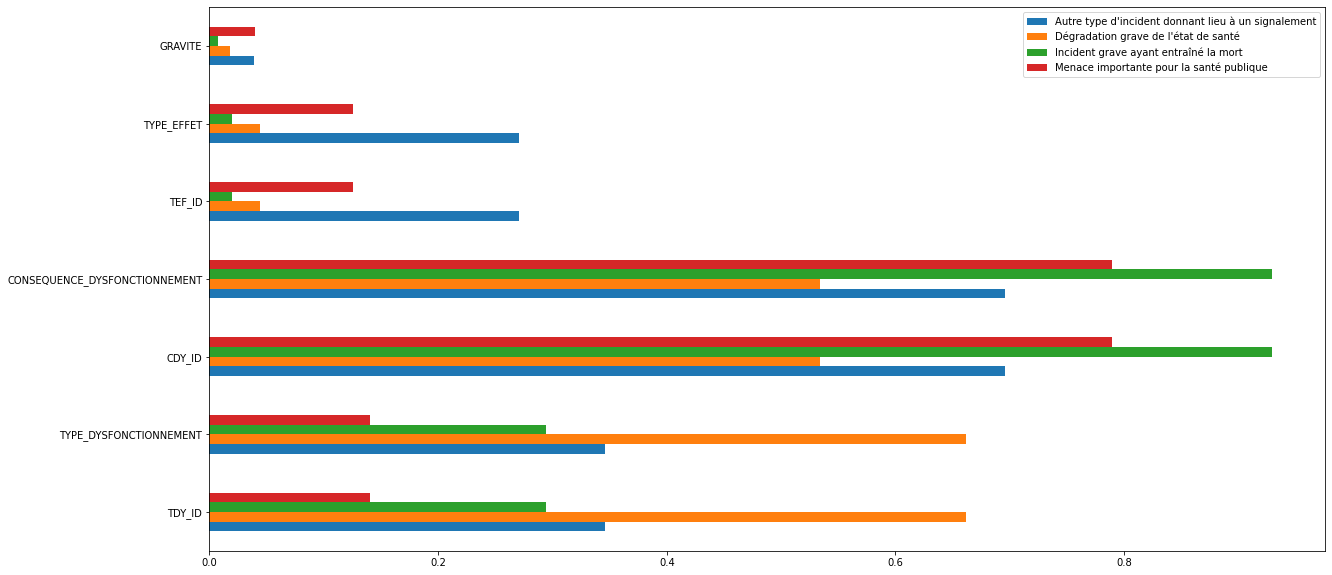

In [9]:
df_group = df_declaration_mrv.groupby('CLASSIFICATION')
col = ['TDY_ID',  'TYPE_DYSFONCTIONNEMENT', 'CDY_ID', 'CONSEQUENCE_DYSFONCTIONNEMENT',
       'TEF_ID', 'TYPE_EFFET', 'GRAVITE' ]
df_1 = df_group.get_group("Autre type d'incident donnant lieu à un signalement")
df_2 = df_group.get_group("Dégradation grave de l'état de santé")
df_3 = df_group.get_group("Incident grave ayant entraîné la mort")
df_4 = df_group.get_group("Menace importante pour la santé publique")
#df_5 = df_group.get_group(np.nan)


L_1 = df_1[col].isna().sum()/len(df_1)
L_2 = df_2[col].isna().sum()/len(df_2)
L_3 = df_3[col].isna().sum()/len(df_3)
L_4 = df_4[col].isna().sum()/len(df_4)

df = pd.DataFrame(index=col)
df["Autre type d'incident donnant lieu à un signalement"] = L_1
df["Dégradation grave de l'état de santé"] = L_2
df["Incident grave ayant entraîné la mort"] = L_3
df["Menace importante pour la santé publique"] = L_4

df.plot(kind='barh',figsize = (20,10))
plt.show()

### Commentaire
Nous espérions reussir avec la reacto et la classification résoudre le problème des NaN mais cela ne nosu aide pas car dans tous les sous groupes que nous avons fait il y a un grand nombre de NaN dans au moins deux des collones TYPE EFFET, CSQ DYSFOCNTIONNEMENT, TYPE_DYSFONCTIONNEMENT


## 0.2 Gestion des NaN

In [10]:
print('Nombre de dysfonctionnement non renseignés' , sum(df_declaration_mrv['TDY_ID'].isna()))
print('Nombre de Consequences dysfonctionnement non renseignés' , sum(df_declaration_mrv['CDY_ID'].isna()))
print('Nombre EFFET non renseignés' , sum(df_declaration_mrv['TEF_ID'].isna()))

Nombre de dysfonctionnement non renseignés 26922
Nombre de Consequences dysfonctionnement non renseignés 53502
Nombre EFFET non renseignés 20353


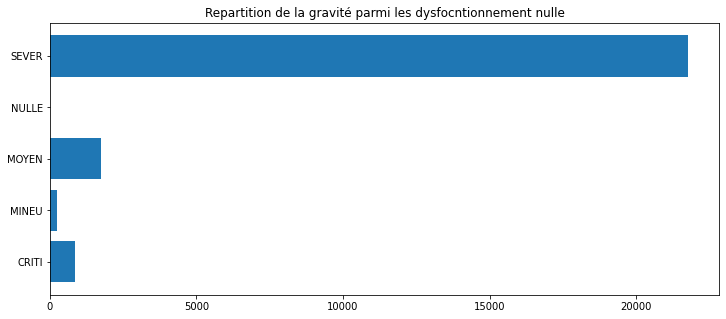

In [11]:
df_null = df_declaration_mrv[df_declaration_mrv['TDY_ID'].isna()]
Y = df_null.groupby(by='GRAVITE')['GRAVITE'].count().to_list()
X = df_null.groupby(by='GRAVITE')['GRAVITE'].count().index
plt.figure(figsize=(12,5))
plt.barh(X,Y)
plt.title ("Repartition de la gravité parmi les dysfocntionnement nulle")
plt.show()

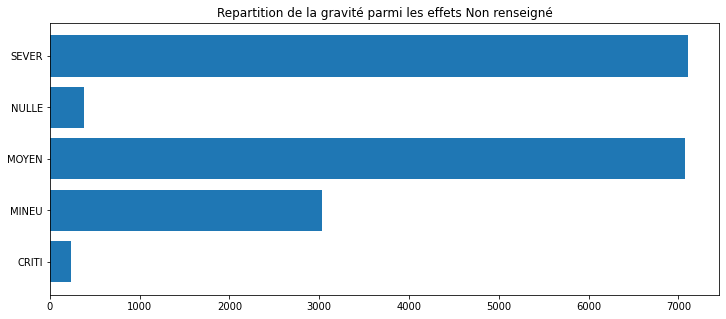

In [12]:
df_null = df_declaration_mrv[df_declaration_mrv['TEF_ID'].isna()]
Y = df_null.groupby(by='GRAVITE')['GRAVITE'].count().to_list()
X = df_null.groupby(by='GRAVITE')['GRAVITE'].count().index
plt.figure(figsize=(12,5))
plt.barh(X,Y)
plt.title ("Repartition de la gravité parmi les effets Non renseigné")
plt.show()

In [13]:
df_declaration_mrv['typo'] = df_declaration_mrv['TDY_ID'].map(lambda x : str(x)) +" "+ df_declaration_mrv['TEF_ID'].map(lambda x :str(x))
print('Nombre typo  non renseignés' , sum(df_declaration_mrv['typo']=="nan nan"))

Nombre typo  non renseignés 3033


In [14]:
len(df_declaration_mrv['typo'].unique())

4991

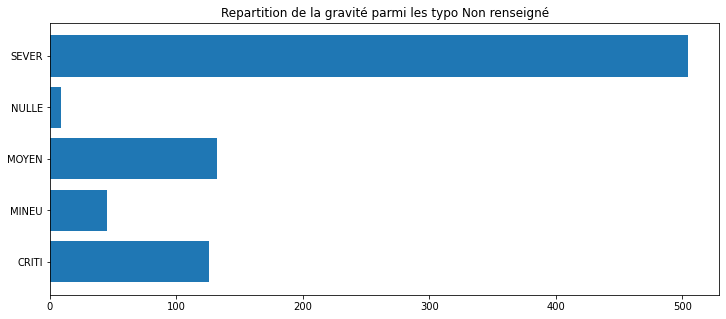

In [15]:
df_null = df_declaration_mrv[df_declaration_mrv['typo']=="nan nan"]
Y = df_null.groupby(by='GRAVITE')['GRAVITE'].count().to_list()
X = df_null.groupby(by='GRAVITE')['GRAVITE'].count().index
plt.figure(figsize=(12,5))
plt.barh(X,Y)
plt.title ("Repartition de la gravité parmi les typo Non renseigné")
plt.show()

In [16]:
df_declaration_mrv['TDY_ID'].unique()[:25]

array(['D1790', 'D1859', 'D1848', 'D2091', 'D1689', 'D1932', 'D1886',
       'D1468', 'D1693', 'D1909', 'D1570', 'D1656', nan, 'D1997', 'D1538',
       'D1625', 'D1539', 'D1854', 'D2219', 'D2047', 'D1759', 'D1756',
       'D1852', 'D1936', 'D1627'], dtype=object)

In [17]:
df_declaration_mrv['CDY_ID'].unique()

array([nan, 'C1032', 'C1097', 'C1098', 'C1037', 'C1030', 'C1117', 'C1024',
       'C1137', 'C1042', 'C1052', 'C1023', 'C1029', 'C1031', 'C1047',
       'C1041', 'C1028', 'C1048', 'C1033', 'C1044', 'C1021', 'C1035',
       'C1043', 'C1040', 'C1046', 'C1036', 'C1059', 'C1078', 'C1027',
       'C1025', 'C1077', 'C1034', 'C1045', 'C1038', 'C1357', 'C1297',
       'C1277', 'C1298', 'C1257', 'C1053', 'C1157', 'C1051', 'C1039',
       'C1319', 'C1320', 'C1079', 'C1318', 'C1057', 'C1022', 'C1405',
       'C1337', 'C1402', 'C1404', 'C1410', 'C1411', 'C1397', 'C1406',
       'C1399', 'C1409', 'C1398', 'C1417', 'C1403', 'C1317'], dtype=object)

In [18]:
df_declaration_mrv['TEF_ID'].unique()[:25]

array(['E1213', 'E1232', nan, 'E1220', 'E1111', 'E1406', 'E1124', 'E1239',
       'E1190', 'E1238', 'E1242', 'E1109', 'E1323', 'E1445', 'E1447',
       'E1449', 'E1451', 'E1454', 'E1467', 'E1444', 'E1448', 'E1450',
       'E1452', 'E1446', 'E1188'], dtype=object)

## Conclusion : 
Pour construire notre classifier, nous devons gérer les valeurs nulles, nous avosn plusieus solution : 
1) Considérer que les valeurs nulles sont équivalentes à l'absence d'effet ou de dysfonctionnement :

    C'est une solution risqué car il existe un champs 'Non renseigné' pour les effets et les dysfonctionnements de plus la répartition de la gravité dans les valeur Nulle nous montre qu'il y a des incident sevère et critiques.

2) Construire le modèle sur les valeurs non nulles

    Cela revient pour le dysfonctionnement à résoudre un problème à 628 classes et dans le cas des effets à 274 classes avec 50 000 lignes

3) Concaténer les effets avec les dysfonctionnements

    Nosu obtenons ainsi 72 000 lignes complètes, mais  i l y a alors ~5000 classes représentés et 274x628 = 172072 classes possibles

4) Utiliser une approche semi-supervisée en considérant les lignes sans classes comme notre working set.
https://github.com/tmadl/semisup-learn

5) Nous pouvons faire 3 modèles imbriqués :
- modèle 1 classification entre possède un effet, possède un dysfonctionnement, ne possède aucun des deux
- modèle 2 pour les dysfonctionnements
- modèle 2.1 pour les effets
- modèle 3 : inférence du type de dysfonctionnement

Dans ce  notebook, nous appliquons simplement le SVM en supprimant les NaN  pour la classification des Des dysfonctionnments et des effets. Pour cela nous utiliserons les variables : 
- DESCRIPTION_INCIDENT',
- 'TYPE_VIGILANCE'
- 'LIBELLE_COMMERCIAL'
- 'REFERENCE_COMMERCIALE',
- 'ETAT_PATIENT',
- 'FABRICANT',
- 'CLASSIFICATION

Pour inférer : 
 - TDY_ID
 - TEF_ID

## 1) Constructions du jeux d'évaluation
On met de coté environ 20% du dataset pour l'évaluation et on ne garde pour l'entrainement seulement les classes avec plus de 10 observations

In [19]:
%%time
df_declaration_mrv = pd.read_csv("data/data_mrv/declaration_mrv_complet.csv")#delimiter=';',encoding='ISO-8859-1')
id_to_dco = pd.read_csv("data/ref_MRV/referentiel_dispositif.csv",delimiter=';',encoding='ISO-8859-1')

#Supression des NaN

#Charegement des colonnes utiles et suppression des NaN

df_tdy = df_declaration_mrv[['DESCRIPTION_INCIDENT','TYPE_VIGILANCE','LIBELLE_COMMERCIAL','DCO_ID',
                         'REFERENCE_COMMERCIALE','ETAT_PATIENT','ACTION_PATIENT','FABRICANT','TDY_ID','CLASSIFICATION']][df_declaration_mrv['TDY_ID'].notna()]
df_tef = df_declaration_mrv[['DESCRIPTION_INCIDENT','TYPE_VIGILANCE','LIBELLE_COMMERCIAL', 'DCO_ID',
                         'REFERENCE_COMMERCIALE','ETAT_PATIENT','ACTION_PATIENT','FABRICANT','TEF_ID','CLASSIFICATION']][df_declaration_mrv['TEF_ID'].notna()]

# On complète les NaN avec du vide
for df in [df_tdy,df_tef] : 
    df['ETAT_PATIENT'] = df['ETAT_PATIENT'].fillna("")
    df['DESCRIPTION_INCIDENT'] = df['DESCRIPTION_INCIDENT'].fillna("")
    df['LIBELLE_COMMERCIAL'] = df['LIBELLE_COMMERCIAL'].fillna("")
    df['FABRICANT'] = df['FABRICANT'].fillna("")
    df["REFERENCE_COMMERCIALE"] = df['REFERENCE_COMMERCIALE'].fillna("")
    df['TYPE_VIGILANCE'] = df['TYPE_VIGILANCE'].fillna("")
    df['CLASSIFICATION'] = df['CLASSIFICATION'].fillna('')
    df['ACTION_PATIENT'] = df['ACTION_PATIENT'].fillna('')
    df['DCO_ID'] = df['DCO_ID'].fillna(-1)
    
    # On ajoute des collones pertinentes
    df['des_lib'] = df['LIBELLE_COMMERCIAL']+ ' ' + df['DESCRIPTION_INCIDENT']
    df['fab_lib'] = df['LIBELLE_COMMERCIAL']+ ' ' + df['FABRICANT']
    df['com'] = df['LIBELLE_COMMERCIAL']+ ' ' + df['REFERENCE_COMMERCIALE']
    df['Text'] = df['LIBELLE_COMMERCIAL']+ ' ' + df['FABRICANT'] + "" + df['DESCRIPTION_INCIDENT']
    
    # On nettoie les données :
    for col in  ['DESCRIPTION_INCIDENT','LIBELLE_COMMERCIAL','ETAT_PATIENT','Text',"des_lib","fab_lib"] :
        df[col] = df[col].map(lambda x: clean_text.preprocess_text(x))

n = 15
# On filtre pour a voir plus de n observations par classse
df_tdy_n = df_tdy.groupby("TDY_ID").filter(lambda x: len(x) > n)
df_tef_n = df_tef.groupby("TEF_ID").filter(lambda x: len(x) > n)

# On encode les labels
le_tdy = LabelEncoder()
df_tdy_n.TDY_ID = le_tdy.fit_transform(df_tdy_n.TDY_ID.values)
le_tef = LabelEncoder()
df_tef_n.TEF_ID = le_tef.fit_transform(df_tef_n.TEF_ID.values)

le = LabelEncoder()
for df_n in [df_tef_n,df_tdy_n]:
    #On encode le type de vigilance
    df_n.TYPE_VIGILANCE = le.fit_transform(df_n.TYPE_VIGILANCE.values)
    #On encode la classifcation 
    df_n.CLASSIFICATION = le.fit_transform(df_n.CLASSIFICATION.values)
    #on encode le DCO
    df_n.DCO_ID = le.fit_transform(df_n.DCO_ID.values)
    # On selection les variables de test en faisant attention aux doublons
train_index_tdy,test_index_tdy = next(GroupShuffleSplit(random_state=1029).split(df_tdy_n, groups=df_tdy_n['DESCRIPTION_INCIDENT']))
train_index_tef,test_index_tef = next(GroupShuffleSplit(random_state=1029).split(df_tef_n, groups=df_tef_n['DESCRIPTION_INCIDENT']))

df_train_tdy, df_test_tdy = df_tdy_n.iloc[train_index_tdy], df_tdy_n.iloc[test_index_tdy]
df_train_tef, df_test_tef = df_tef_n.iloc[train_index_tef], df_tef_n.iloc[test_index_tef]


CPU times: user 54.9 s, sys: 452 ms, total: 55.4 s
Wall time: 55.4 s


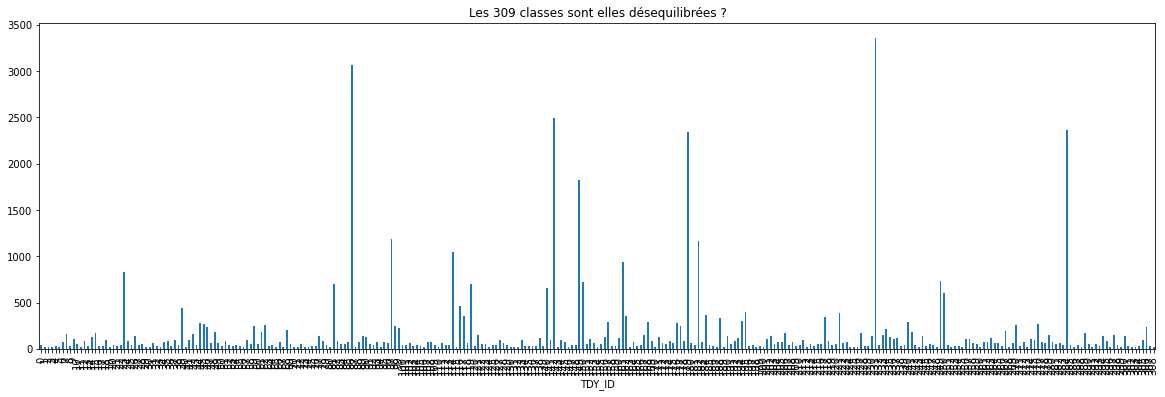

In [20]:
df_tdy_n.groupby('TDY_ID').count()['Text'].plot(kind ='bar',figsize=(20,6))
plt.title("Les "+ str(len(df_tdy_n['TDY_ID'].unique())) +" classes sont elles désequilibrées ?")
plt.show()

## 2) Construction du pipeline  pour le type de dysfonctionnement

In [77]:
%%time
preprocess = ColumnTransformer(
    [('etat_pat_tfidf', TfidfVectorizer(sublinear_tf=True, min_df=3,ngram_range=(1, 1),
                                       stop_words=STOP_WORDS,
                                       max_features = 10000,norm = 'l2'), 'ETAT_PATIENT'),
     
     ('description_tfidf',TfidfVectorizer(sublinear_tf=True, min_df=5,
                            ngram_range=(1, 1),
                            stop_words=STOP_WORDS,
                            max_features = 10000,norm = 'l2'), 'DESCRIPTION_INCIDENT'),
     
     ('action_pat_tfidf',TfidfVectorizer(sublinear_tf=True, min_df=3,
                           ngram_range=(1, 1),
                           stop_words=STOP_WORDS,
                           max_features = 10000,norm = 'l2'), 'ACTION_PATIENT'),
     
     ('fabricant_tfidf',TfidfVectorizer(sublinear_tf=True, min_df=3,
                           ngram_range=(1, 1),
                           stop_words=STOP_WORDS,
                           max_features = 5000,norm = 'l2'), 'FABRICANT'),
     
     ('com_tfidf',TfidfVectorizer(sublinear_tf=True, min_df=3,
                           ngram_range=(1, 1),
                           stop_words=STOP_WORDS,
                           max_features = 5000,norm = 'l2'),'com')
     
    ],
    #
    remainder='passthrough')


pipeline = Pipeline([
    ('vect', preprocess),
    ('clf', CalibratedClassifierCV(LinearSVC(class_weight='balanced'),cv=3, method='isotonic')),
])

X = df_train_tdy[['CLASSIFICATION','TYPE_VIGILANCE','DESCRIPTION_INCIDENT','ETAT_PATIENT','ACTION_PATIENT','FABRICANT','com']] # 
y = df_train_tdy.TDY_ID
CV = 5

result= cross_validate(pipeline, X, y, scoring=['accuracy','balanced_accuracy','f1_weighted' ], cv=CV)

CPU times: user 10min 17s, sys: 2.46 s, total: 10min 20s
Wall time: 10min 20s


In [84]:
pd.DataFrame(result)[['test_accuracy','test_balanced_accuracy','test_f1_weighted']].mean()

test_accuracy             0.427544
test_balanced_accuracy    0.334295
test_f1_weighted          0.400729
dtype: float64

In [87]:
%%time
preprocess = ColumnTransformer(
    [('etat_pat_tfidf', TfidfVectorizer(sublinear_tf=True, min_df=3,ngram_range=(1, 1),
                                       stop_words=STOP_WORDS,
                                       max_features = 10000,norm = 'l2'), 'ETAT_PATIENT'),
     
     ('description_tfidf',TfidfVectorizer(sublinear_tf=True, min_df=5,
                            ngram_range=(1, 1),
                            stop_words=STOP_WORDS,
                            max_features = 10000,norm = 'l2'), 'DESCRIPTION_INCIDENT'),
     
     ('action_pat_tfidf',TfidfVectorizer(sublinear_tf=True, min_df=3,
                           ngram_range=(1, 1),
                           stop_words=STOP_WORDS,
                           max_features = 10000,norm = 'l2'), 'ACTION_PATIENT'),
     
     ('fabricant_tfidf',TfidfVectorizer(sublinear_tf=True, min_df=3,
                           ngram_range=(1, 1),
                           stop_words=STOP_WORDS,
                           max_features = 5000,norm = 'l2'), 'FABRICANT'),
     
     ('com_tfidf',TfidfVectorizer(sublinear_tf=True, min_df=3,
                           ngram_range=(1, 1),
                           stop_words=STOP_WORDS,
                           max_features = 5000,norm = 'l2'),'com')
     
    ],
    #
    remainder='passthrough')

X = df_train_tdy[['CLASSIFICATION','TYPE_VIGILANCE','DESCRIPTION_INCIDENT','ETAT_PATIENT','ACTION_PATIENT','FABRICANT','com']] # 
y = df_train_tdy.TDY_ID
CV = 3
    
models = [
    MultinomialNB(),
    LogisticRegression(random_state=0)
]

df_result = pd.DataFrame(index = ['test_accuracy','test_balanced_accuracy','test_f1_weighted'])

for model in models : 
    model_name = model.__class__.__name__
    
    pipeline = Pipeline([
        ('vect', preprocess),
        ('svd', TruncatedSVD(n_components=2500, random_state=42)),
        ('clf', model),
    ])
    
   
    
    result= cross_validate(pipeline, X, y, scoring=['accuracy','balanced_accuracy','f1_weighted' ], cv=CV)
    df_result[model_name] = pd.DataFrame(result)[['test_accuracy','test_balanced_accuracy','test_f1_weighted']].mean().values



CPU times: user 2h 51min 2s, sys: 2h 6min 12s, total: 4h 57min 15s
Wall time: 33min 13s


In [88]:
df_result

,MultinomialNB,LogisticRegression
test_accuracy,NaN,0.387787
test_balanced_accuracy,NaN,0.184540
test_f1_weighted,NaN,0.352148


### Commentaire : 
La meilleure performance étant : Accuracy = 0.40 et balanced_accuracy = 0.33 et f1_weighted = 0.40 avec un SVM


Les meilleures performances des modèles de machine Learning,obenue à partir d'un pieline très proche du DCO ne sont pas très satisfesantes. Pour l'améliorer voici quelques pistes : 
- Features Selection :
    - Mieux comprendre le process métier pour mieux identifier ou se situe le  l'information
    - Utiliser le DCO_ID et faire un modèle pour chaque DCO_ID
- Features Transformation : 
    - Fine tuner le Tfidf
    - Changer de representations
- Data Augmentation:
    - Appliquer des méthodes semi-supervisé afin d'augementer la diversité des observations
- Model selection :
    - Appliquer XGboost (sans doute trop long car le nombre de classe est elevé)
    - Appliquer des modèles de Deep Learning

Regardons rapidement si on inclut le DCO_ID :

In [21]:
%%time
preprocess = ColumnTransformer(
    [('etat_pat_tfidf', TfidfVectorizer(sublinear_tf=True, min_df=3,ngram_range=(1, 1),
                                       stop_words=STOP_WORDS,
                                       max_features = 10000,norm = 'l2'), 'ETAT_PATIENT'),
     
     ('description_tfidf',TfidfVectorizer(sublinear_tf=True, min_df=5,
                            ngram_range=(1, 1),
                            stop_words=STOP_WORDS,
                            max_features = 10000,norm = 'l2'), 'DESCRIPTION_INCIDENT'),
     
     ('action_pat_tfidf',TfidfVectorizer(sublinear_tf=True, min_df=3,
                           ngram_range=(1, 1),
                           stop_words=STOP_WORDS,
                           max_features = 10000,norm = 'l2'), 'ACTION_PATIENT'),
     
     ('fabricant_tfidf',TfidfVectorizer(sublinear_tf=True, min_df=3,
                           ngram_range=(1, 1),
                           stop_words=STOP_WORDS,
                           max_features = 5000,norm = 'l2'), 'FABRICANT'),
     
     ('com_tfidf',TfidfVectorizer(sublinear_tf=True, min_df=3,
                           ngram_range=(1, 1),
                           stop_words=STOP_WORDS,
                           max_features = 5000,norm = 'l2'),'com')
     
    ],
    #
    remainder='passthrough')


pipeline = Pipeline([
    ('vect', preprocess),
    ('clf', CalibratedClassifierCV(LinearSVC(class_weight='balanced'),cv=3, method='isotonic')),
])

X = df_train_tdy[['DCO_ID','CLASSIFICATION','TYPE_VIGILANCE','DESCRIPTION_INCIDENT','ETAT_PATIENT','ACTION_PATIENT','FABRICANT','com']] # 
y = df_train_tdy.TDY_ID
CV = 3

result= cross_validate(pipeline, X, y, scoring=['accuracy','balanced_accuracy','f1_weighted' ], cv=CV)

CPU times: user 1h 34min 11s, sys: 3.46 s, total: 1h 34min 14s
Wall time: 1h 34min 14s


In [22]:
pd.DataFrame(result)[['test_accuracy','test_balanced_accuracy','test_f1_weighted']].mean()

test_accuracy             0.337545
test_balanced_accuracy    0.152764
test_f1_weighted          0.278708
dtype: float64

## 3) Construction du pipeline  pour le type d'effet

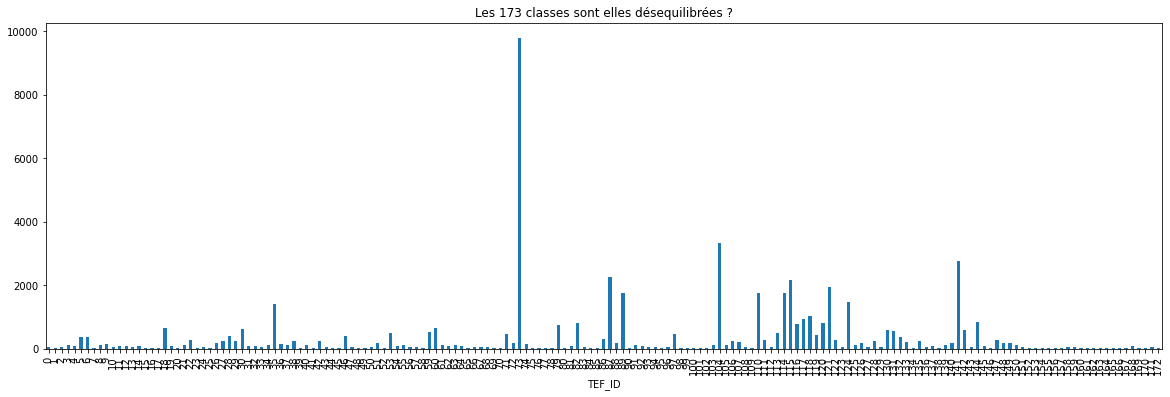

In [100]:
df_tef_n.groupby('TEF_ID').count()['Text'].plot(kind ='bar',figsize=(20,6))
plt.title("Les "+ str(len(df_tef_n['TEF_ID'].unique())) +" classes sont elles désequilibrées ?")
plt.show()

In [108]:
%%time
preprocess = ColumnTransformer(
    [('etat_pat_tfidf', TfidfVectorizer(sublinear_tf=True, min_df=3,ngram_range=(1, 1),
                                       stop_words=STOP_WORDS,
                                       max_features = 10000,norm = 'l2'), 'ETAT_PATIENT'),
     
     ('description_tfidf',TfidfVectorizer(sublinear_tf=True, min_df=5,
                            ngram_range=(1, 1),
                            stop_words=STOP_WORDS,
                            max_features = 10000,norm = 'l2'), 'DESCRIPTION_INCIDENT'),
     
     ('action_pat_tfidf',TfidfVectorizer(sublinear_tf=True, min_df=3,
                           ngram_range=(1, 1),
                           stop_words=STOP_WORDS,
                           max_features = 10000,norm = 'l2'), 'ACTION_PATIENT'),
     
     ('fabricant_tfidf',TfidfVectorizer(sublinear_tf=True, min_df=3,
                           ngram_range=(1, 1),
                           stop_words=STOP_WORDS,
                           max_features = 5000,norm = 'l2'), 'FABRICANT'),
     
     ('com_tfidf',TfidfVectorizer(sublinear_tf=True, min_df=3,
                           ngram_range=(1, 1),
                           stop_words=STOP_WORDS,
                           max_features = 5000,norm = 'l2'),'com')
     
    ],
    #
    remainder='passthrough')


pipeline = Pipeline([
    ('vect', preprocess),
    ('clf', CalibratedClassifierCV(LinearSVC(class_weight='balanced'),cv=3, method='isotonic')),
])

X = df_train_tef[['CLASSIFICATION','TYPE_VIGILANCE','DESCRIPTION_INCIDENT','ETAT_PATIENT','ACTION_PATIENT','FABRICANT','com']] # 
y = df_train_tef.TEF_ID
CV = 3

result= cross_validate(pipeline, X, y, scoring=['accuracy','balanced_accuracy','f1_weighted' ], cv=CV)

CPU times: user 5min 58s, sys: 0 ns, total: 5min 58s
Wall time: 5min 58s


In [109]:
pd.DataFrame(result)[['test_accuracy','test_balanced_accuracy','test_f1_weighted']].mean()

test_accuracy             0.337353
test_balanced_accuracy    0.158543
test_f1_weighted          0.276191
dtype: float64

In [113]:
%%time
preprocess = ColumnTransformer(
    [('description_tfidf',TfidfVectorizer(sublinear_tf=True, min_df=5,
                            ngram_range=(1, 1),
                            stop_words=STOP_WORDS,
                            max_features = 10000,norm = 'l2'), 'DESCRIPTION_INCIDENT')
     
    ],
    #
    remainder='passthrough')


pipeline = Pipeline([
    ('vect', preprocess),
    ('clf', CalibratedClassifierCV(LinearSVC( class_weight='balanced'),cv=3, method='isotonic')),
])

X = df_train_tef[['DESCRIPTION_INCIDENT']] # 
y = df_train_tef.TEF_ID
CV = 3

result= cross_validate(pipeline, X, y, scoring=['accuracy','balanced_accuracy','f1_weighted' ], cv=CV)

CPU times: user 12min 46s, sys: 0 ns, total: 12min 46s
Wall time: 12min 46s


In [112]:
pd.DataFrame(result)[['test_accuracy','test_balanced_accuracy','test_f1_weighted']].mean()

test_accuracy             0.307636
test_balanced_accuracy    0.159809
test_f1_weighted          0.243208
dtype: float64

### Commentaire : 
La meilleure performance étant : Accuracy = 0.30 et balanced_accuracy = 0.15 et f1_weighted = 0.24 avec un SVM


Les meilleures performances des modèles de machine Learning,obenue à partir d'un pieline très proche du DCO ne sont pas du tout satisfaisantes. Pour l'améliorer voici quelques pistes : 
- Features Selection :
    - Mieux comprendre le process métier pour mieux identifier ou se situe le  l'information
    - Utiliser le DCO_ID et faire un modèle pour chaque DCO_ID
- Features Transformation : 
    - Fine tuner le Tfidf
    - Changer de representations
- Data Augmentation:
    - Appliquer des méthodes semi-supervisées afin d'augementer la diversité des observations
- Model selection :
    - Appliquer XGboost (sans doute trop long car le nombre de classe est elevé)
    - Appliquer des modèle de Deep Learning


In [117]:
from frameworks.SelfLearning import *